In [1]:
import pandas as pd
import hdbscan 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score

### Подготовка

In [6]:
df = pd.read_csv("clean_data.csv").head(50000)

In [7]:
columns_to_one_hot_encode = ['carrier', 'origin', 'dest']
columns_to_normalize = ['arr_delay', 'dep_delay', 'distance']

# One-hot encoding using Pandas
one_hot_encoded_df = pd.get_dummies(df[columns_to_one_hot_encode])

# Normalization using Pandas
normalized_df = (df[columns_to_normalize] - df[columns_to_normalize].mean()) / df[columns_to_normalize].std()

# Combine the processed data
processed_df = pd.concat([one_hot_encoded_df, normalized_df], axis=1)
processed_df

,carrier_9E,carrier_AA,carrier_AS,carrier_B6,carrier_DL,carrier_EV,carrier_F9,carrier_FL,carrier_HA,carrier_MQ,...,dest_STL,dest_STT,dest_SYR,dest_TPA,dest_TUL,dest_TYS,dest_XNA,arr_delay,dep_delay,distance
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0.211934,-0.198007,0.511159
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0.459789,-0.136483,0.533098
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0.817802,-0.198007,0.084721
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,-0.586711,-0.290292,0.752488
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,-0.779487,-0.444100,-0.363657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,0.074236,0.017325,-0.009891
49996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,-0.641790,-0.413338,2.137384
49997,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,-0.228698,-0.505623,-0.009891
49998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,-0.063461,-0.167245,1.956388


In [8]:
X_train, X_test, y_train, y_test = train_test_split(processed_df, df.is_delayed, test_size=0.2, random_state=12)

### K-Means (К-средних)

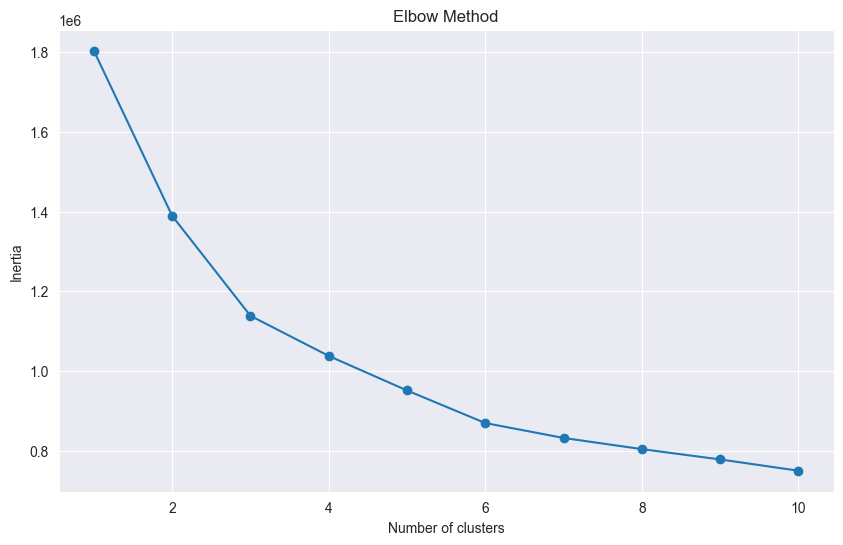

In [5]:
inertia = []
for i in range(1, 11):  # testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(processed_df)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


In [6]:
km = KMeans(n_clusters=3, init = 'k-means++', max_iter = 400, n_init = 10, random_state=12)
km.fit(X_train)
km_res = km.predict(X_test)
print(metrics.rand_score(y_test, km_res))

0.5317398039978306


In [7]:
print('KMeans:')
print('macro', metrics.jaccard_score(y_test, km_res, average='macro'))
print('micro', metrics.jaccard_score(y_test, km_res, average='micro'))
print('weighted', metrics.jaccard_score(y_test, km_res, average='weighted'))

KMeans:
macro 0.16660387400375784
micro 0.24464767844240787
weighted 0.2405715935743314


In [8]:
#[-1; 1] - at 6 cl = 0.195
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_train, km.labels_))
#the bigger the better - at 6 cl = 56264
print("Calinski-Harabasz Index: %0.3f" % calinski_harabasz_score(X_train, km.labels_))
#the lower the better - at 6 cl - 1.605
print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(X_train, km.labels_))

Silhouette Coefficient: 0.239
Calinski-Harabasz Index: 76455.492
Davies-Bouldin Index: 1.387


Text(0, 0.5, 'Data')

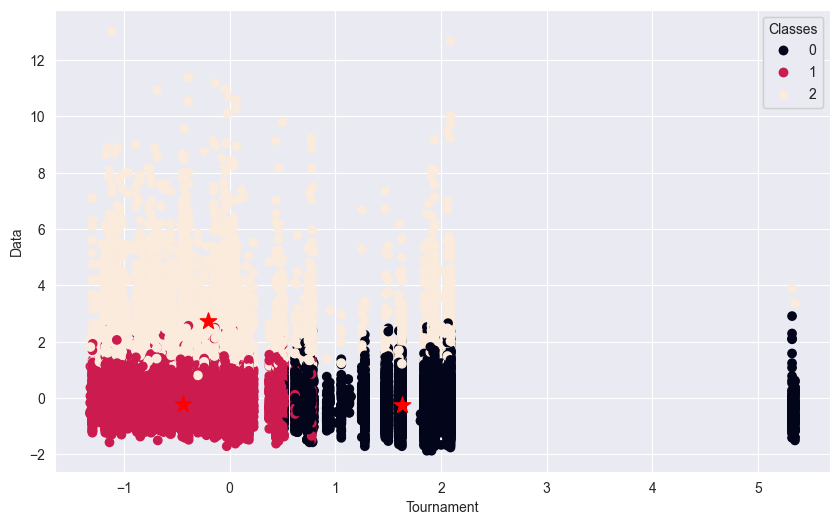

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(X_test.iloc[:,-1], X_test.iloc[:,-3], c = km_res)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),loc="best", title="Classes")
scatter= ax.scatter(km.cluster_centers_[:,-1], km.cluster_centers_[:,-3], s = 150, c = 'red', marker = '*')
ax.add_artist(legend1)
plt.xlabel("Tournament")
plt.ylabel("Data")

### DBSCAN

In [26]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=4)
dbscan_res = clusterer.fit_predict(X_train)
"""
dbscan = DBSCAN(eps=100, min_samples=40)
dbscan_res = dbscan.fit_predict(X_train) """
print(set(dbscan_res))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [27]:
print('DBSCAN')
print('Rand:', metrics.rand_score(y_train, dbscan_res))
print('macro', metrics.jaccard_score(y_train, (dbscan_res > -1), average='macro'))
print('micro', metrics.jaccard_score(y_train, (dbscan_res > -1), average='micro'))
print('weighted', metrics.jaccard_score(y_train, (dbscan_res > -1), average='weighted'))

DBSCAN
Rand: 0.4764937185929648
macro 0.19677828849554013
micro 0.20922639741225552
weighted 0.17410488560976925


In [28]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_train, dbscan_res))
print("Calinski-Harabasz Index: %0.3f" % calinski_harabasz_score(X_train, dbscan_res))
print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(X_train, dbscan_res))

Silhouette Coefficient: 0.259
Calinski-Harabasz Index: 75.961
Davies-Bouldin Index: 1.319


Text(0, 0.5, 'Data')

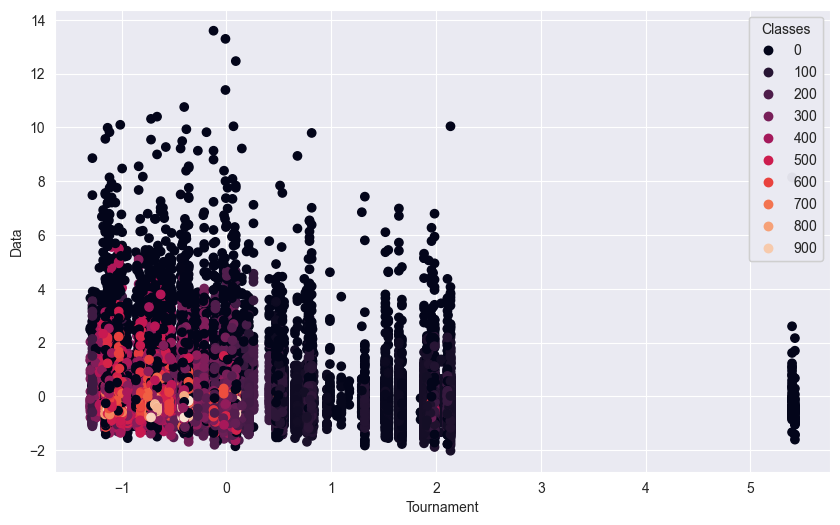

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(X_train.iloc[:,-1], X_train.iloc[:,-3], c = dbscan_res)
legend1 = ax.legend(*scatter.legend_elements(),loc="best", title="Classes")
ax.add_artist(legend1)
plt.xlabel("Tournament")
plt.ylabel("Data")

### Иерархическая кластеризация

In [9]:
ag = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
ag_res = ag.fit_predict(X_train)
print(set(ag.labels_))

{0, 1, 2}


In [11]:
print('Иерархическая кластеризация:')
print('Rand:', metrics.rand_score(y_train, ag_res))
print('macro', metrics.jaccard_score(y_train, ag_res, average='macro'))
print('micro', metrics.jaccard_score(y_train,  ag_res, average='micro'))
print('weighted', metrics.jaccard_score(y_train,  ag_res, average='weighted'))

Иерархическая кластеризация:
Rand: 0.5767732893322333
macro 0.08243668288183584
micro 0.12444831754420488
weighted 0.09579281423664981


In [12]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_train, ag_res))
print("Calinski-Harabasz Index: %0.3f" % calinski_harabasz_score(X_train, ag_res))
print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(X_train, ag_res))

Silhouette Coefficient: 0.242
Calinski-Harabasz Index: 9843.180
Davies-Bouldin Index: 1.375


Text(0, 0.5, 'Data')

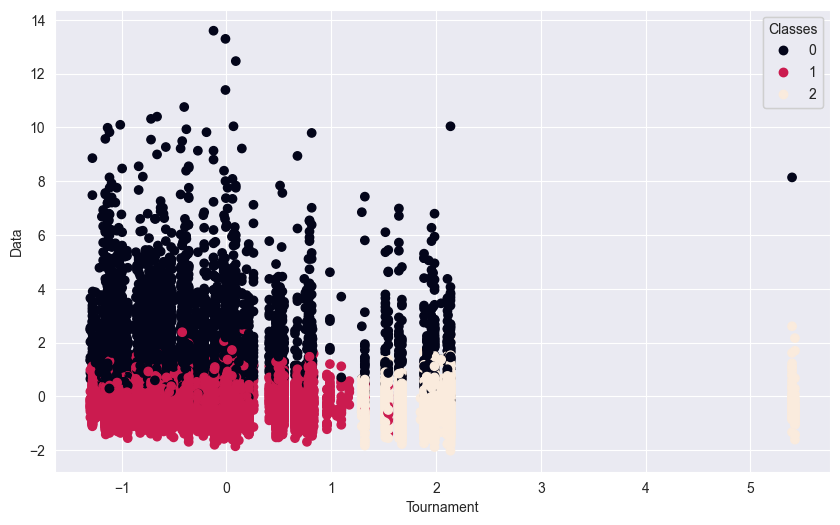

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(X_train.iloc[:,-1], X_train.iloc[:,-3], c = ag_res)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),loc="best", title="Classes")
ax.add_artist(legend1)
plt.xlabel("Tournament")
plt.ylabel("Data")